In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import json
import numpy 
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import pyarrow
import sys

from datetime import date
from dotenv import load_dotenv
from sqlalchemy import create_engine
from os import path
from typing import List,Dict, Tuple
from collections import defaultdict
pd.set_option("display.max_columns", None)

load_dotenv(verbose=True)
BIGQUERY_CREDENTIALS_PATH = os.environ.get('BIGQUERY_CREDENTIALS_PATH')
engine = create_engine('bigquery://bespoke-financial/ProdMetrcData', credentials_path=os.path.expanduser(BIGQUERY_CREDENTIALS_PATH))

sys.path.append(path.realpath(path.join(os.getcwd(), "../core")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../src")))

import create_queries
import prepare_data

from bespoke.inventory.analysis.shared import download_util, inventory_types
from bespoke.inventory.analysis import active_inventory_util as util
from bespoke.inventory.analysis import inventory_valuations_util as valuations_util

%load_ext autoreload
%autoreload 2

In [3]:
# Define company name and date ranges

In [71]:
COMPANY_IDENTIFIER = ['IDC']
TRANSFER_PACKAGES_START_DATE = '2020-01-01'
SALES_TRANSACTIONS_START_DATE = '2020-01-01'

In [5]:
#fetch download report and lisences
company_licenses_query = create_queries.create_company_licenses_query(COMPANY_IDENTIFIER)
company_download_summaries_query = create_queries.create_company_download_summaries_query(COMPANY_IDENTIFIER, TRANSFER_PACKAGES_START_DATE)

company_licenses_dataframe = pd.read_sql_query(company_licenses_query, engine)
company_download_summaries_dataframe = pd.read_sql_query(company_download_summaries_query, engine)

In [6]:
print(company_download_summaries_query)


		select
			companies.id as company_id,
			companies.identifier as company_identifier,
			metrc_download_summaries.license_number,
			metrc_download_summaries.date,
			metrc_download_summaries.status
		from
			metrc_download_summaries
			inner join companies on metrc_download_summaries.company_id = companies.id
		where
			True
			and companies.identifier in ("IDC")
			and metrc_download_summaries.date >= "2020-01-01"
			
		order by
			date desc
	


## Check download status summaries

In [7]:
license_numbers = company_download_summaries_dataframe['license_number'].unique()
download_summary_records = company_download_summaries_dataframe.to_dict('records')

In [8]:
license_numbers

array(['C9-0000320-LIC'], dtype=object)

In [9]:
def check_company_license_download(license_numbers: List[str],download_summary_records: List[Dict[str,str]]) -> Dict[str,str]:
    license_number_to_download_summary_records = {}

    for license_number in license_numbers:
        license_number_to_download_summary_records[license_number] = list(filter(
            lambda download_summary_record: download_summary_record['license_number'] == license_number,
            download_summary_records
        ))

    bad_count = 0
    bad_history = defaultdict(list)
    for license_number, download_summary_records in license_number_to_download_summary_records.items():
        print(f'Verifying download summaries for license {license_number}...')
        print(f'Earliest download summary: {download_summary_records[-1]["date"]}')
        print(f'Latest download summary: {download_summary_records[0]["date"]}')
        for download_summary_record in download_summary_records:
            if download_summary_record['status'] != 'completed':
                bad_count += 1
                print(f'Found bad download summary for license {license_number} on date {download_summary_record["date"]}') 
                bad_history[license_number].append(download_summary_record['date'])            
        
        print('')
    if bad_count > 0:
        print(f'[FAILURE] Found a total of {bad_count} bad download summaries')
    else:
        print(f'[SUCCESS] All download summaries look good!')
    return bad_history



In [10]:
bad_download_history = check_company_license_download(license_numbers,download_summary_records)

Verifying download summaries for license C9-0000320-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-02-22

[SUCCESS] All download summaries look good!


In [11]:
bad_download_history

defaultdict(list, {})

## Choose license numbers

In [12]:
# get list of retailer license numbers
license_numbers = list(company_licenses_dataframe[company_licenses_dataframe['license_category'].isin(['Retailer', 'Multiple'])]['license_number'].unique())
license_numbers

['C9-0000320-LIC']

In [13]:
# run this if only has 1 license, or only want 1 license
#license_numbers = [license_numbers[0]]
#license_numbers

# License check

In [14]:
retial_license_check_df = company_licenses_dataframe[company_licenses_dataframe['license_number'].isin(license_numbers)][['license_number','license_category','is_current','license_status']].reset_index(drop = True)
retial_license_check_df['license_check'] = ['YES' if retial_license_check_df['license_status'][i] == 'Active' or str(retial_license_check_df['is_current'][i]) == 'True' else 'NO' for i in range(len(retial_license_check_df))]


In [15]:
retial_license_check_df

,license_number,license_category,is_current,license_status,license_check
0,C9-0000320-LIC,Retailer,True,Active,YES


## Pull data

In [16]:
company_incoming_transfer_packages_query = create_queries.create_company_incoming_transfer_packages_query(
    COMPANY_IDENTIFIER,
    TRANSFER_PACKAGES_START_DATE,
    license_numbers=license_numbers,
)
company_outgoing_transfer_packages_query = create_queries.create_company_outgoing_transfer_packages_query(
    COMPANY_IDENTIFIER,
    TRANSFER_PACKAGES_START_DATE,
    license_numbers=license_numbers,
)
company_unknown_transfer_packages_query = create_queries.create_company_unknown_transfer_packages_query(
    COMPANY_IDENTIFIER,
    TRANSFER_PACKAGES_START_DATE,
#     license_numbers=license_numbers,
)
company_sales_transactions_query = create_queries.create_company_sales_transactions_query(
    COMPANY_IDENTIFIER,
    SALES_TRANSACTIONS_START_DATE,
    license_numbers=license_numbers,
)
company_sales_receipts_query = create_queries.create_company_sales_receipts_query(
    COMPANY_IDENTIFIER,
    SALES_TRANSACTIONS_START_DATE,
    license_numbers=license_numbers,
)
company_sales_receipts_with_transactions_query = create_queries.create_company_sales_receipts_with_transactions_query(
    COMPANY_IDENTIFIER,
    SALES_TRANSACTIONS_START_DATE,
    license_numbers=license_numbers,
)
company_inventory_packages_query = create_queries.create_company_inventory_packages_query(
    COMPANY_IDENTIFIER,
    include_quantity_zero=True,
    license_numbers=license_numbers,
)

company_incoming_transfer_packages_dataframe = pd.read_sql_query(company_incoming_transfer_packages_query, engine)
company_outgoing_transfer_packages_dataframe = pd.read_sql_query(company_outgoing_transfer_packages_query, engine)
company_unknown_transfer_packages_dataframe = pd.read_sql_query(company_unknown_transfer_packages_query, engine)
company_sales_transactions_dataframe = pd.read_sql_query(company_sales_transactions_query, engine)
company_sales_receipts_dataframe = pd.read_sql_query(company_sales_receipts_query, engine)
company_sales_receipts_with_transactions_dataframe = pd.read_sql_query(company_sales_receipts_with_transactions_query, engine)
company_inventory_packages_dataframe = pd.read_sql_query(company_inventory_packages_query, engine)

In [17]:
#make sure we did pulled all location's data
company_incoming_transfer_packages_dataframe['license_number'].unique()

array(['C9-0000320-LIC'], dtype=object)

In [18]:
company_sales_receipts_with_transactions_dataframe['license_number'].unique()

array(['C9-0000320-LIC'], dtype=object)

In [19]:
company_inventory_packages_dataframe['license_number'].unique()

array(['C9-0000320-LIC'], dtype=object)

## Unknown transfer packages

In [20]:
def check_unknown_transfer_packages(unknown_transfer_df: pd.DataFrame) -> int:
    unknown_package_count = unknown_transfer_df.shape[0]
    if unknown_package_count > 0:
        print(f'[FAILURE] Found a total of {unknown_package_count} unknown transfer packages')
    else:
        print(f'[SUCCESS] No unknown transfer packages!')
    return unknown_package_count

In [21]:
unknown_package_count = check_unknown_transfer_packages(company_unknown_transfer_packages_dataframe)
unknown_package_count

[SUCCESS] No unknown transfer packages!


0

## Receiver wholesale price coverage

In [22]:
def check_receiver_wholesale_price_coverage(incoming_transfer_df: pd.DataFrame) -> float:
    rwp_exists_count = incoming_transfer_df[incoming_transfer_df['receiver_wholesale_price'].notnull()].shape[0]
    total_count = incoming_transfer_df.shape[0]
    rwp_coverage = round(rwp_exists_count / total_count, 2) * 100
    print(f'{rwp_coverage}% of incoming transfer packages have receiver wholesale price')
    return rwp_coverage

In [23]:
company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['receiver_wholesale_price'].notnull()].shape

(2828, 32)

In [24]:
company_incoming_transfer_packages_dataframe.shape

(2964, 32)

In [25]:
rwp_coverage = check_receiver_wholesale_price_coverage(company_incoming_transfer_packages_dataframe)


95.0% of incoming transfer packages have receiver wholesale price


## dedupe sales transactions

In [26]:
deduped_sales_receipts_with_transactions_dataframe = prepare_data.dedupe_sales_transactions(company_sales_receipts_with_transactions_dataframe)

In [27]:
deduped_sales_receipts_with_transactions_dataframe['sales_month'] = deduped_sales_receipts_with_transactions_dataframe['sales_datetime'].dt.strftime('%Y-%m')

In [28]:
#check we have all locations
deduped_sales_receipts_with_transactions_dataframe['license_number'].unique()

array(['C9-0000320-LIC'], dtype=object)

## Trxns missing incoming transfer packages

In [29]:
def check_incoming_transfer_package_coverage(incoming_transfer_df: pd.DataFrame,sales_df: pd.DataFrame) -> Tuple[List,pd.DataFrame]:
    package_transfer_sales_merged = pd.merge(sales_df,incoming_transfer_df,left_on='tx_package_id', right_on='package_id', how='left')
    package_transfer_sales_merged_missed = package_transfer_sales_merged[package_transfer_sales_merged['package_id'].isnull()]
    count_trxn_missed = package_transfer_sales_merged_missed.shape[0]
    count_total_trxn = sales_df.shape[0]
    missed_ratio = count_trxn_missed/ count_total_trxn
    print(f'# transactions missing incoming transfer package: {count_trxn_missed} ({count_trxn_missed / count_total_trxn * 100}%)')
    print(f'# transactions total: {count_total_trxn}')
    return missed_ratio,package_transfer_sales_merged_missed

In [30]:
incoming_transfer_package_coverage,incoming_transfer_package_coverage_missing = check_incoming_transfer_package_coverage(company_incoming_transfer_packages_dataframe,deduped_sales_receipts_with_transactions_dataframe)

# transactions missing incoming transfer package: 0 (0.0%)
# transactions total: 111241


In [31]:
month_to_missing_count = incoming_transfer_package_coverage_missing[['sales_month','receipt_number']].groupby(['sales_month']).apply(lambda x: len(x['receipt_number'].unique()))
month_to_missing_count


,sales_month,receipt_number
sales_month,,


## Receipts missing metrc_sales_transactions

In [32]:
sales_receipt_with_transactions_records = deduped_sales_receipts_with_transactions_dataframe.to_dict('records')

receipt_number_to_transactions = {}
for sales_receipt_with_transaction_record in sales_receipt_with_transactions_records:
    receipt_number = sales_receipt_with_transaction_record['receipt_number']
    if receipt_number in receipt_number_to_transactions:
        receipt_number_to_transactions[receipt_number] += [sales_receipt_with_transaction_record]
    else:
        receipt_number_to_transactions[receipt_number] = [sales_receipt_with_transaction_record]

In [33]:
import math

def float_eq(receipt_total_price: float, transactions_total_price: float, num_transactions: int) -> bool:
    # For every additional transaction, increase threshold by 0.01 (a penny).
    threshold = num_transactions * 0.1
    return math.isclose(receipt_total_price, transactions_total_price, abs_tol=threshold)

mismatch_count = 0 # Count of receipts where receipt total price does not match transactions total price.
missing_count = 0 # Count of receipts with no transactions.
total_count = 0 # Count of receipts (including those missing transactions).

mismatch_over_count = 0
mismatch_under_count = 0

month_to_mismatch_count = {}
month_to_missing_count = {}

month_to_mismatch_over_count = {}
month_to_mismatch_under_count = {}

example_mismatch_over_receipts = []
example_mismatch_under_receipts = []

for receipt_number, receipt_transactions in list(receipt_number_to_transactions.items()):
    receipt_total_price = receipt_transactions[0]['rt_total_price']
    receipt_sales_month = receipt_transactions[0]['sales_month']
    receipt_total_packages = receipt_transactions[0]['total_packages']

    total_count += 1

    if len(receipt_transactions) == 1 and receipt_transactions[0]['tx_package_id'] == None:
        missing_count += 1
        if receipt_sales_month not in month_to_missing_count:
            month_to_missing_count[receipt_sales_month] = 0
        month_to_missing_count[receipt_sales_month] += 1
        continue

    # Check whether 'total_packages' field of sales receipt matches number of transactions related to receipt.
    if receipt_total_packages != len(receipt_transactions):
        missing_count += 1
        if receipt_sales_month not in month_to_missing_count:
            month_to_missing_count[receipt_sales_month] = 0
        month_to_missing_count[receipt_sales_month] += 1
        continue

    transactions_total_price = sum(receipt_transaction['tx_total_price'] for receipt_transaction in receipt_transactions)
    if not float_eq(receipt_total_price, transactions_total_price, len(receipt_transactions)):
        mismatch_count += 1
        if receipt_total_price < transactions_total_price:
            mismatch_over_count += 1
            example_mismatch_over_receipts += [(receipt_number, receipt_transactions)]
        else:
            mismatch_under_count += 1
            example_mismatch_under_receipts += [(receipt_number, receipt_transactions)]

        if receipt_sales_month not in month_to_mismatch_count:
            month_to_mismatch_count[receipt_sales_month] = 0
        month_to_mismatch_count[receipt_sales_month] += 1
        continue

print(f'# receipts with mismatching transactions: {mismatch_count} ({mismatch_count / total_count * 100}%)')
print(f'# receipts missing transactions: {missing_count} ({missing_count / total_count * 100}%)')
print(f'# receipts total: {total_count}')

if mismatch_count:
    print(f'# mismatch receipt vs transactions (transactions over): {mismatch_over_count} ({mismatch_over_count / mismatch_count * 100}%)')
    print(f'# mismatch receipt vs transactions (transactions under): {mismatch_under_count} ({mismatch_under_count / mismatch_count * 100}%)')

# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 60628


In [34]:
company_sales_receipts_dataframe['sales_month'] = company_sales_receipts_dataframe['sales_datetime'].dt.strftime('%Y-%m')

<AxesSubplot:xlabel='sales_month'>

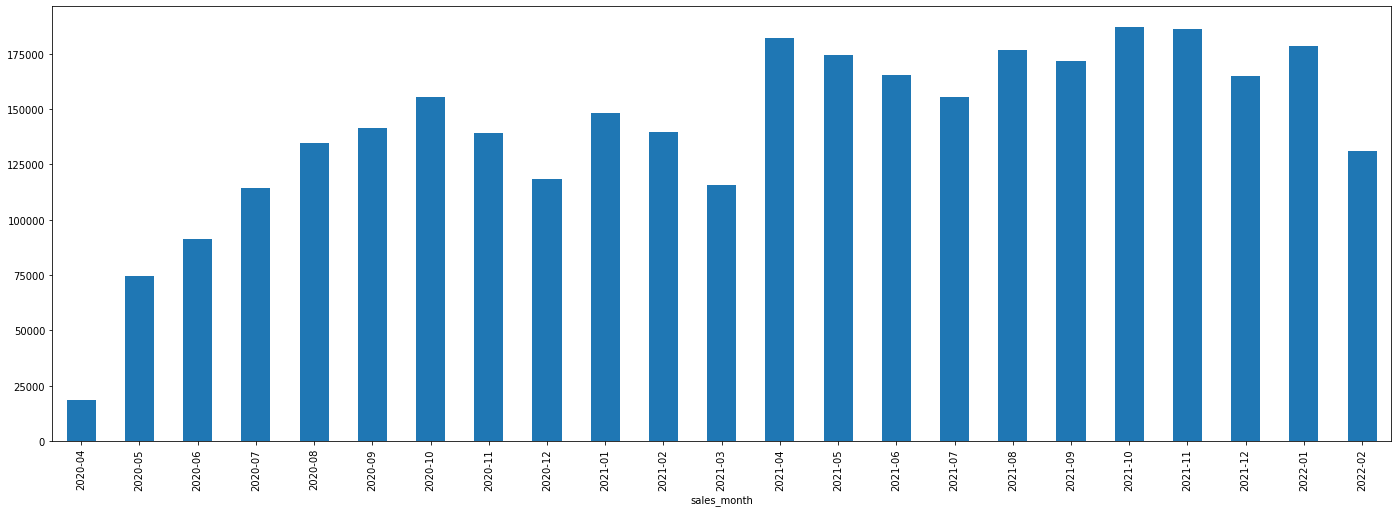

In [35]:
company_sales_receipts_dataframe.groupby(['sales_month'])['total_price'].sum().plot.bar(figsize=(24, 8), stacked=True)

# For Embarc only

In [ ]:
if COMPANY_IDENTIFIER == ['EMA','EMM','EMT']:
    #incoming transfer
    company_incoming_transfer_packages_dataframe_ema = company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['license_number'] == 'C10-0000774-LIC']
    company_incoming_transfer_packages_dataframe_emm = company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['license_number'] == 'C10-0000786-LIC']
    company_incoming_transfer_packages_dataframe_emt = company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['license_number'] == 'C10-0000695-LIC']
    #sales & receipt
    deduped_sales_receipts_with_transactions_dataframe_ema = deduped_sales_receipts_with_transactions_dataframe[deduped_sales_receipts_with_transactions_dataframe['license_number'] == 'C10-0000774-LIC']
    deduped_sales_receipts_with_transactions_dataframe_emm = deduped_sales_receipts_with_transactions_dataframe[deduped_sales_receipts_with_transactions_dataframe['license_number'] == 'C10-0000786-LIC']
    deduped_sales_receipts_with_transactions_dataframe_emt = deduped_sales_receipts_with_transactions_dataframe[deduped_sales_receipts_with_transactions_dataframe['license_number'] == 'C10-0000695-LIC']
    #inventory
    company_inventory_packages_dataframe_ema = company_inventory_packages_dataframe[company_inventory_packages_dataframe['license_number'] == 'C10-0000774-LIC']
    company_inventory_packages_dataframe_emm = company_inventory_packages_dataframe[company_inventory_packages_dataframe['license_number'] == 'C10-0000786-LIC']
    company_inventory_packages_dataframe_emt = company_inventory_packages_dataframe[company_inventory_packages_dataframe['license_number'] == 'C10-0000695-LIC']
    

# For BUD

In [ ]:
if COMPANY_IDENTIFIER == ['BUD']:
    #incoming transfer
    company_incoming_transfer_packages_dataframe_sac = company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['license_number'] == 'C9-0000399-LIC']
    company_incoming_transfer_packages_dataframe_fresno = company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['license_number'] == 'C9-0000467-LIC']
    company_incoming_transfer_packages_dataframe_la = company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['license_number'] == 'C9-0000464-LIC']
    #sales & receipt
    deduped_sales_receipts_with_transactions_dataframe_sac = deduped_sales_receipts_with_transactions_dataframe[deduped_sales_receipts_with_transactions_dataframe['license_number'] == 'C9-0000399-LIC']
    deduped_sales_receipts_with_transactions_dataframe_fresno = deduped_sales_receipts_with_transactions_dataframe[deduped_sales_receipts_with_transactions_dataframe['license_number'] == 'C9-0000467-LIC']
    deduped_sales_receipts_with_transactions_dataframe_la = deduped_sales_receipts_with_transactions_dataframe[deduped_sales_receipts_with_transactions_dataframe['license_number'] == 'C9-0000464-LIC']
    #inventory
    company_inventory_packages_dataframe_sac = company_inventory_packages_dataframe[company_inventory_packages_dataframe['license_number'] == 'C9-0000399-LIC']
    company_inventory_packages_dataframe_fresno = company_inventory_packages_dataframe[company_inventory_packages_dataframe['license_number'] == 'C9-0000467-LIC']
    company_inventory_packages_dataframe_la = company_inventory_packages_dataframe[company_inventory_packages_dataframe['license_number'] == 'C9-0000464-LIC']
    

In [ ]:
company_inventory_packages_dataframe_la['license_number'].unique()

# Vendor churn

In [36]:
WINDOW = 4
VC_START_DATE = '2020-01-01'
VC_END_DATE = '2022-02-01'
VC_MONTH_LIST = ['2021-10-01','2021-11-01','2021-12-01','2022-01-01']
VC_MONTH_END = VC_MONTH_LIST[-1]

In [37]:
def calculate_vendor_churn(incoming_transfer_df,license_list,vc_windown,vc_start_date,vc_end_date,vc_month_list,vc_month_end):
    df_vendor_churn = incoming_transfer_df[incoming_transfer_df['license_number'].isin(license_list)]
    df_vendor_churn['year_month'] = pd.to_datetime(df_vendor_churn['created_date']).dt.strftime("%Y-%m")
    vc = df_vendor_churn[['year_month','shipper_facility_name','shipper_wholesale_price']].groupby(['year_month','shipper_facility_name']).sum().reset_index()
    vc= vc.assign(year_month=lambda df:pd.to_datetime(df['year_month']))

    vc_full = (
        vc
        .groupby('shipper_facility_name').apply(
            lambda df: df.merge(
            pd.Series(
                None, 
                index = pd.date_range(start = vc_start_date, end = vc_end_date, freq = 'MS'), 
                name='__place_holder'
            ), 
            how ='right',
            left_on = 'year_month', 
            right_index=True,
        ).assign(
            **{
                "shipper_facility_name": lambda df_: df_.shipper_facility_name.dropna().unique()[0],
                "shipper_wholesale_price": lambda df_: df_.shipper_wholesale_price.fillna(0),
            }
        )
        .drop('__place_holder', axis=1)
        )
    ).reset_index(drop=True)
    
    rolling_4m_sum =  vc_full.groupby('shipper_facility_name').apply(
    lambda df: df.set_index('year_month').sort_index().rolling(vc_windown).sum()
    )
    rolling_4m_sum.columns = ['rolling_4m_total_price']
    facility_monthly_running_total = vc_full.groupby('shipper_facility_name').apply(
        lambda df: df.set_index('year_month').sort_index()['shipper_wholesale_price'].cumsum().to_frame()
    )
    facility_monthly_running_total.columns = ['facility_running_total']
    monthly_running_total = facility_monthly_running_total.reset_index().groupby('year_month')['facility_running_total'].sum().to_frame()
    monthly_running_total.columns = ['monthly_running_total']

    vc_result = rolling_4m_sum.merge(
        facility_monthly_running_total,
        how='inner',
        left_index=True,
        right_index=True
    ).reset_index().merge(
        monthly_running_total,
        how='left',
        on = 'year_month'
    )
    vc_result['%_total'] = vc_result['facility_running_total'] / vc_result['monthly_running_total']
    vc_result['last_4m_active'] = vc_result['rolling_4m_total_price'] > 0
    vc_result ['significant'] = vc_result['%_total'] > 0.001
    vc_result['measure'] = vc_result.apply(
    lambda row: "Active"  if (row['last_4m_active'] & row['significant']) else ("Inactive" if row['significant'] else "Exclude"),
    axis=1
    )
    #churn
    churn = vc_result.groupby(['year_month']).apply(lambda x: x[x['measure'] == 'Inactive']['%_total'].sum()).reset_index()
    churn.columns = ['year_month','%_inactive']
    churn.index = churn.year_month
    
    # output vendor churn matrix
    vc_data = vc_full[vc_full['year_month'] <= VC_MONTH_END]
    vc_data['year_month'] = vc_data['year_month'].astype(str)
    vc_matrix = pd.pivot_table(vc_data, values='shipper_wholesale_price', index='shipper_facility_name',
    columns='year_month', fill_value=0).reset_index()
    vc_matrix['facility_total'] = vc_matrix.sum(axis= 1)
    vc_matrix['grand_total'] = vc_matrix['facility_total'].sum()
    vc_matrix['perc_total'] = vc_matrix['facility_total'] / vc_matrix['grand_total']
    vc_matrix['last_4m_total'] = vc_matrix[VC_MONTH_LIST].sum(axis = 1)
    vc_matrix['last_4m_active'] = vc_matrix['last_4m_total'] > 0
    vc_matrix ['significant'] = vc_matrix['perc_total'] > 0.001
    vc_matrix['measure'] = vc_matrix.apply(
        lambda row: "Active"  if (row['last_4m_active'] & row['significant']) else ("Inactive" if row['significant'] else "Exclude"),
        axis=1
    )
    return churn, vc_matrix
    


## embarc

In [ ]:
churn_ema,vc_matrix_ema = calculate_vendor_churn(company_incoming_transfer_packages_dataframe_ema,['C10-0000774-LIC'],WINDOW,VC_START_DATE,VC_END_DATE,VC_MONTH_LIST,VC_MONTH_END)
churn_emm,vc_matrix_emm = calculate_vendor_churn(company_incoming_transfer_packages_dataframe_emm,['C10-0000786-LIC'],WINDOW,VC_START_DATE,VC_END_DATE,VC_MONTH_LIST,VC_MONTH_END)
churn_emt,vc_matrix_emt = calculate_vendor_churn(company_incoming_transfer_packages_dataframe_emt,['C10-0000695-LIC'],WINDOW,VC_START_DATE,VC_END_DATE,VC_MONTH_LIST,VC_MONTH_END)



## BUD

In [ ]:
churn_sac,vc_matrix_sac = calculate_vendor_churn(company_incoming_transfer_packages_dataframe_sac,['C9-0000399-LIC'],WINDOW,VC_START_DATE,VC_END_DATE,VC_MONTH_LIST,VC_MONTH_END)
churn_fresno,vc_matrix_fresno = calculate_vendor_churn(company_incoming_transfer_packages_dataframe_fresno,['C9-0000467-LIC'],WINDOW,VC_START_DATE,VC_END_DATE,VC_MONTH_LIST,VC_MONTH_END)
churn_la,vc_matrix_la = calculate_vendor_churn(company_incoming_transfer_packages_dataframe_la,['C9-0000464-LIC'],WINDOW,VC_START_DATE,VC_END_DATE,VC_MONTH_LIST,VC_MONTH_END)



In [ ]:
churn_la

In [ ]:
ax = churn_la['%_inactive'].plot(marker = 'o',figsize = (12,8))
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
ax = plt.title('Rolling 4m vendor churn')

## other

In [38]:
license_numbers

['C9-0000320-LIC']

In [39]:
churn,vc_matrix = calculate_vendor_churn(company_incoming_transfer_packages_dataframe,license_numbers,WINDOW,VC_START_DATE,VC_END_DATE,VC_MONTH_LIST,VC_MONTH_END)

In [40]:
churn

,year_month,%_inactive
year_month,,
2020-01-01,2020-01-01,0.000000
2020-02-01,2020-02-01,0.000000
2020-03-01,2020-03-01,1.000000
2020-04-01,2020-04-01,0.000000
2020-05-01,2020-05-01,0.000000
2020-06-01,2020-06-01,0.000000
2020-07-01,2020-07-01,0.000000
2020-08-01,2020-08-01,0.101428
2020-09-01,2020-09-01,0.084768


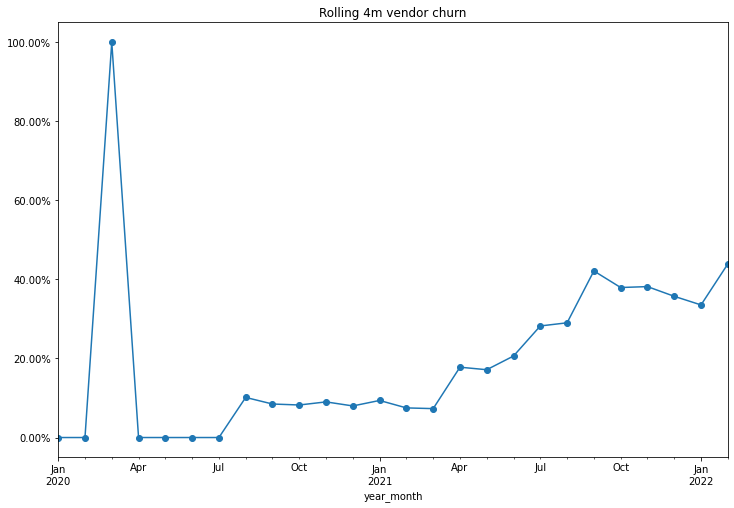

In [41]:
ax = churn['%_inactive'].plot(marker = 'o',figsize = (12,8))
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
ax = plt.title('Rolling 4m vendor churn')

# Receiver wholesale price outlier check

In [42]:
def check_per_unit_incoming(incoming_transfer_df: pd.DataFrame) -> Tuple[pd.DataFrame,pd.DataFrame]:
    incoming_transfer_df['per_unit_incoming'] = incoming_transfer_df['shipper_wholesale_price'] / incoming_transfer_df['shipped_quantity']
    # by package ID
    per_unit_incoming_package_sort = incoming_transfer_df[['package_id','per_unit_incoming']].groupby(['package_id']).mean().sort_values(by = 'per_unit_incoming',ascending = False).reset_index()
    per_unit_incoming_package_top5 = per_unit_incoming_package_sort[0:5]
    print('printing per unit incoming by package ID summary ...')
    print(f'max per unit incoming: {per_unit_incoming_package_sort["per_unit_incoming"][0]}' + f' from package ID: {per_unit_incoming_package_sort["package_id"][0]}')
    print(f'min per unit incoming: {per_unit_incoming_package_sort.dropna()["per_unit_incoming"][-1:].values[0]}' + f' from package ID: {per_unit_incoming_package_sort.dropna()["package_id"][-1:].values[0]}')
    #print(per_unit_incoming_package_top5)
    print('')
    
    #by product name
    per_unit_incoming_product_sort = incoming_transfer_df[['product_name','per_unit_incoming']].groupby(['product_name']).max().sort_values(by = 'per_unit_incoming',ascending = False).reset_index()
    per_unit_incoming_product_top5 = per_unit_incoming_product_sort[0:5]
    #print('printing per unit incoming by product name summary ...')
    #print(f'max per unit incoming: {per_unit_incoming_product_sort["per_unit_incoming"][0]}' + f' from product name: {per_unit_incoming_product_sort["product_name"][0]}')
    #print(f'min per unit incoming: {per_unit_incoming_product_sort.dropna()["per_unit_incoming"][-1:].values[0]}' + f' from product_name: {per_unit_incoming_product_sort.dropna()["product_name"][-1:].values[0]}')
    #print(per_unit_incoming_product_top5)
    return per_unit_incoming_package_sort,per_unit_incoming_product_sort


In [43]:
per_unit_incoming_package_sort,per_unit_incoming_product_sort = check_per_unit_incoming(company_incoming_transfer_packages_dataframe)


printing per unit incoming by package ID summary ...
max per unit incoming: inf from package ID: 13270560
min per unit incoming: 4.098360655737705e-05 from package ID: 15924786



In [44]:
# top 5
print('Top 5 per unit incoming packages')
per_unit_incoming_package_sort.head(5)

Top 5 per unit incoming packages


,package_id,per_unit_incoming
0,13270560,inf
1,3742569,95.25
2,14217381,68.00
3,22032877,65.00
4,22033473,65.00


In [45]:
print('Bottom 5 per unit incoming packages')
per_unit_incoming_package_sort.dropna().tail(5)


Bottom 5 per unit incoming packages


,package_id,per_unit_incoming
2924,13477892,0.000052
2925,19103721,0.000050
2926,15844126,0.000044
2927,15844802,0.000041
2928,15924786,0.000041


In [46]:
company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['per_unit_incoming'] > 10000]

,delivery_type,license_number,manifest_number,created_date,received_datetime,shipment_transaction_type,shipper_facility_license_number,shipper_facility_name,recipient_facility_license_number,recipient_facility_name,shipment_type_name,shipment_transaction_type_1,package_id,package_label,type,source_package_labels,source_harvest_names,shipment_package_state,is_testing_sample,is_trade_sample,product_category_name,product_name,package_lab_results_status,shipper_wholesale_price,shipped_quantity,shipped_unit_of_measure,receiver_wholesale_price,received_quantity,received_unit_of_measure,receiver_wholesale_price_1,item_unit_weight,item_unit_weight_unit_of_measure_name,per_unit_incoming
1586,INCOMING_FROM_VENDOR,C9-0000320-LIC,0001807555,2021-04-13,2021-04-15 23:26:34+00:00,Wholesale,C11-0000032-LIC,CI DISTRIBUTION LLC,C9-0000320-LIC,IN DA CUT LLC,Wholesale Manifest,Wholesale,13270560,1A406030000326B000059660,transfer,1A406030000326B000056181,Chem D 2/15/21,Accepted,False,False,Flower (packaged eighth - each),Claybourne Co. 3.5g - Sample - Chem Dawg,passed,0.01,0.0,Each,0.01,1.0,Each,0.01,3.5,Grams,inf


# COGS analysis

In [47]:
def cogs_analysis(df_in:pd.DataFrame,df_sales:pd.DataFrame,freq: str) -> Tuple[pd.DataFrame,pd.DataFrame]:
    df_sales['per_unit'] = df_sales['tx_total_price'] / df_sales['tx_quantity_sold']
    # set frequency
    if freq == 'monthly':
        df_sales['date'] = df_sales['sales_datetime'].dt.strftime("%Y-%m")
    elif freq == 'weekly':
        df_sales['date'] = df_sales['sales_datetime'].dt.strftime("%Y-%W")
        df_sales['week'] = df_sales['sales_datetime'].dt.strftime("%W")
    # total # of trxns
    s_total_count = df_sales.groupby('date')['tx_total_price'].count()
    df_total_count = pd.Series(s_total_count).to_frame()
    df_total_count = df_total_count.reset_index()
    df_total_count.rename(columns={'tx_total_price':'total_count'}, inplace=True)
    # revenue
    s_revenue = df_sales.groupby('date')['tx_total_price'].sum()
    df_revenue = pd.Series(s_revenue).to_frame()
    df_revenue = df_revenue.reset_index()
    df_revenue.rename(columns={'tx_total_price': 'revenue'}, inplace=True)

    df_in['per_unit_incoming'] = df_in['shipper_wholesale_price'] / df_in['shipped_quantity']
    
    # per unit price by package id
    df_in_price = df_in[df_in['shipper_wholesale_price'].notnull()]
    average_incoming_package_id = df_in_price.groupby('package_id')['per_unit_incoming'].mean()
    df_avg_incoming_price = pd.Series(average_incoming_package_id).to_frame()
    df_avg_incoming_price = df_avg_incoming_price.reset_index()
    # per unit price by product name
    average_incoming_product = df_in_price.groupby('product_name')['per_unit_incoming'].mean()
    df_avg_product = pd.Series(average_incoming_product).to_frame()
    df_avg_product = df_avg_product.reset_index()
    df_avg_product.rename(columns={'per_unit_incoming':'per_unit_product'}, inplace=True)

    # merge with (cogs by package id)
    df_cogs_package_id = pd.merge(df_sales, df_avg_incoming_price, left_on='tx_package_id', right_on='package_id', how='left')
    df_cogs_package_id['total_incoming'] = df_cogs_package_id['per_unit_incoming'] * df_cogs_package_id['tx_quantity_sold']
    df_cogs_package_id.replace([numpy.inf], numpy.nan, inplace=True)
    df_cogs_package_id_notnull = df_cogs_package_id[df_cogs_package_id['total_incoming'].notnull()]

    # sum cogs by package id
    s_cogs = df_cogs_package_id_notnull.groupby('date')['total_incoming'].sum()
    df_cogs_id = pd.Series(s_cogs).to_frame()
    df_cogs_id = df_cogs_id.reset_index()
    # count # of trxn by package id
    s_cogs_count = df_cogs_package_id_notnull.groupby('date')['total_incoming'].count()
    df_cogs_count = pd.Series(s_cogs_count).to_frame()
    df_cogs_count = df_cogs_count.reset_index()
    df_cogs_count.rename(columns={'total_incoming':'count_incoming'}, inplace=True)
    
    # merge with (cogs by product name)
    df_cogs_average_product = pd.merge(df_cogs_package_id, df_avg_product, left_on='tx_product_name', right_on='product_name', how='left')
    df_cogs_average_product['total_product'] = df_cogs_average_product['tx_quantity_sold'] * df_cogs_average_product['per_unit_product']
    df_cogs_null = df_cogs_average_product[df_cogs_average_product['per_unit_incoming'].isnull()]
    df_cogs_product = df_cogs_null[df_cogs_null['per_unit_product'].notnull()]
    # sum cogs filldown by product name
    product_sum = df_cogs_product.groupby('date')['total_product'].sum()
    df_product_sum = pd.Series(product_sum).to_frame()
    df_product_sum = df_product_sum.reset_index()
    df_product_sum.rename(columns={'total_product':'product_sum'}, inplace=True)
    # count # of trxn filldown by product name
    product_count = df_cogs_product.groupby('date')['total_product'].count()
    df_product_count = pd.Series(product_count).to_frame()
    df_product_count = df_product_count.reset_index()
    df_product_count.rename(columns={'total_product':'product_count'}, inplace=True)
    df_cogs_product_df = pd.merge(df_product_sum, df_product_count)
    
    # prepare summary
    df_summary = pd.merge(df_revenue, df_cogs_product_df, how='left')
    df_summary = pd.merge(df_summary, df_cogs_id, how='left')
    df_summary['product_sum'] = df_summary['product_sum'].fillna(0)
    df_summary['product_count'] = df_summary['product_count'].fillna(0)
    # total cogs = by product id cogs + by product name cogs
    df_summary['cogs'] = df_summary['total_incoming'] + df_summary['product_sum']
    df_summary = pd.merge(df_summary, df_cogs_count)
    df_summary = pd.merge(df_summary, df_total_count)
    # total count = by package id count + by product count
    df_summary['total_count_incoming'] = df_summary['count_incoming'] + df_summary['product_count']
    df_summary['margin_$'] = df_summary['revenue'] - df_summary['cogs']
    df_summary['margin_%'] = df_summary['margin_$'] / df_summary['revenue']
    df_summary['coverage'] = df_summary['total_count_incoming'] / df_summary['total_count']
    df_summary_simp = df_summary[['date', 'revenue', 'cogs', 'margin_$', 'margin_%', 'total_count_incoming','product_count','count_incoming', 'coverage']]
    
    return df_summary_simp,df_cogs_average_product




In [48]:
df_in = company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['per_unit_incoming'] <= 10000]
df_inventory = company_inventory_packages_dataframe
df_sales = deduped_sales_receipts_with_transactions_dataframe

## others

In [49]:
df_summary_simp,df_cogs_average_product = cogs_analysis(df_in,df_sales,'monthly')
df_summary_simp['gm_past_quarter'] = df_summary_simp[['margin_%']].rolling(3).mean().values
df_summary_simp['gm_past_2quarters'] = df_summary_simp[['margin_%']].rolling(6).mean().values
df_summary_simp['gm_past_3quarters'] = df_summary_simp[['margin_%']].rolling(9).mean().values
df_summary_simp['sum_cogs_past_3months'] = df_summary_simp[['cogs']].rolling(3).sum().values
df_summary_simp['revenue_change'] = df_summary_simp['revenue'].pct_change()
df_summary_simp.index = df_summary_simp.date 


In [50]:
df_summary_simp

,date,revenue,cogs,margin_$,margin_%,total_count_incoming,product_count,count_incoming,coverage,gm_past_quarter,gm_past_2quarters,gm_past_3quarters,sum_cogs_past_3months,revenue_change
date,,,,,,,,,,,,,,
2020-04,2020-04,18656.38,14948.454981,3707.925019,0.198748,657.0,0.0,657,1.000000,NaN,NaN,NaN,NaN,NaN
2020-05,2020-05,74564.97,69500.871150,5064.098850,0.067915,2503.0,0.0,2503,0.999601,NaN,NaN,NaN,NaN,2.996754
2020-06,2020-06,91486.89,80547.794344,10939.095656,0.119570,2593.0,0.0,2593,0.989695,0.128745,NaN,NaN,164997.120475,0.226942
2020-07,2020-07,114290.13,84833.127031,29457.002969,0.257739,3261.0,0.0,3261,0.979868,0.148408,NaN,NaN,234881.792526,0.249251
2020-08,2020-08,134714.98,59473.702028,75241.277972,0.558522,3812.0,0.0,3812,0.940770,0.311944,NaN,NaN,224854.623404,0.178711
2020-09,2020-09,141376.77,65886.789717,75489.980283,0.533963,4185.0,0.0,4185,0.978490,0.450075,0.289410,NaN,210193.618777,0.049451
2020-10,2020-10,155566.91,72436.845785,83130.064215,0.534369,4535.0,0.0,4535,0.971092,0.542285,0.345346,NaN,197797.337531,0.100371
2020-11,2020-11,139322.57,67399.664293,71922.905707,0.516233,4280.0,0.0,4280,0.965922,0.528188,0.420066,NaN,205723.299795,-0.104420
2020-12,2020-12,118430.74,52953.669375,65477.070625,0.552872,3619.0,0.0,3619,0.917829,0.534491,0.492283,0.371103,192790.179453,-0.149953


# Revenue change vs state

In [51]:
def gmv_change_variance_point_mapping(x):
    if x < -0.1:
        return -5
    elif x >= -0.1 and x <-0.05:
        return -2.5
    elif x >= -0.05 and x < 0:
        return 0
    elif x >= 0 and x < 0.05:
        return 5
    else:
        return 10
    

### for CA

In [52]:
def calculate_quarterly_sum_gmv_ca(cogs_analysis_df):
    #2020
    sum_gmv_q1_2020 = cogs_analysis_df[(cogs_analysis_df['date']>= '2020-01')&(cogs_analysis_df['date']<= '2020-03')]['revenue'].sum()
    sum_gmv_q2_2020 = cogs_analysis_df[(cogs_analysis_df['date']>= '2020-04')&(cogs_analysis_df['date']<= '2020-06')]['revenue'].sum()
    sum_gmv_q3_2020 = cogs_analysis_df[(cogs_analysis_df['date']>= '2020-07')&(cogs_analysis_df['date']<= '2020-09')]['revenue'].sum()
    sum_gmv_q4_2020 = cogs_analysis_df[(cogs_analysis_df['date']>= '2020-10')&(cogs_analysis_df['date']<= '2020-12')]['revenue'].sum()
    #2021
    sum_gmv_q1_2021 = cogs_analysis_df[(cogs_analysis_df['date']>= '2021-01')&(cogs_analysis_df['date']<= '2021-03')]['revenue'].sum()
    sum_gmv_q2_2021 = cogs_analysis_df[(cogs_analysis_df['date']>= '2021-04')&(cogs_analysis_df['date']<= '2021-06')]['revenue'].sum()
    sum_gmv_q3_2021 = cogs_analysis_df[(cogs_analysis_df['date']>= '2021-07')&(cogs_analysis_df['date']<= '2021-09')]['revenue'].sum()
    sum_gmv_q4_2021 = cogs_analysis_df[(cogs_analysis_df['date']>= '2021-10')&(cogs_analysis_df['date']<= '2021-12')]['revenue'].sum()
    gmv_df = pd.DataFrame([sum_gmv_q1_2020,sum_gmv_q2_2020,sum_gmv_q3_2020,sum_gmv_q4_2020,\
                  sum_gmv_q1_2021,sum_gmv_q2_2021,sum_gmv_q3_2021,sum_gmv_q4_2021])
    gmv_df.columns = ['sum_gmv']
    gmv_df['sum_gmv_change'] = gmv_df['sum_gmv'].pct_change().values
    gmv_df['sum_gmv_change_ca'] = [0.1,0.19,0.19,0.16,-0.07,0.01,-0.1,numpy.nan]
    gmv_df['weight'] = [numpy.nan,numpy.nan,0.04,0.28,0.52,0.76,1,numpy.nan]
    gmv_df['variance'] = gmv_df['sum_gmv_change'] - gmv_df['sum_gmv_change_ca']
    gmv_df['points'] = [gmv_change_variance_point_mapping(n) for n in gmv_df['variance']]
    gmv_df.replace([numpy.inf, -numpy.inf], numpy.nan, inplace=True)
    gmv_df['total'] = gmv_df['points'] * gmv_df['weight']
    gmv_df.index = ['2020Q1','2020Q2','2020Q3','2020Q4','2021Q1','2021Q2','2021Q3','2021Q4']
    #gmv_df = gmv_df.dropna()
    return gmv_df
    

In [53]:
a = calculate_quarterly_sum_gmv_ca(df_summary_simp)
a

,sum_gmv,sum_gmv_change,sum_gmv_change_ca,weight,variance,points,total
2020Q1,0.00,NaN,0.10,NaN,NaN,10,NaN
2020Q2,184708.24,NaN,0.19,NaN,NaN,10,NaN
2020Q3,390381.88,1.113505,0.19,0.04,0.923505,10,0.4
2020Q4,413320.22,0.058759,0.16,0.28,-0.101241,-5,-1.4
2021Q1,403291.09,-0.024265,-0.07,0.52,0.045735,5,2.6
2021Q2,521412.00,0.292892,0.01,0.76,0.282892,10,7.6
2021Q3,503792.38,-0.033792,-0.10,1.00,0.066208,10,10.0
2021Q4,538565.97,0.069024,NaN,NaN,NaN,10,NaN


In [54]:
round(a.dropna()['total'].sum(),2)

19.2

### FOR MA

In [ ]:
def calculate_quarterly_sum_gmv_ma(cogs_analysis_df):

    gmv_df = cogs_analysis_df[(cogs_analysis_df['date'] >= '2021-09')&(cogs_analysis_df['date'] <= '2022-01')][['revenue_change']]
    gmv_df['sum_gmv_change_ma'] = [-0.07,0.01,-0.07,0.09,-0.11]
    gmv_df['weight'] = [0.68,0.76,0.84,0.92,1]
    gmv_df['variance'] = gmv_df['revenue_change'] - gmv_df['sum_gmv_change_ma']
    gmv_df['points'] = [gmv_change_variance_point_mapping(n) for n in gmv_df['variance']]
    gmv_df.replace([numpy.inf, -numpy.inf], numpy.nan, inplace=True)
    gmv_df['total'] = gmv_df['points'] * gmv_df['weight']
    return gmv_df
    

In [ ]:
a = calculate_quarterly_sum_gmv_ma(df_summary_simp)

In [ ]:
a

In [ ]:
round(a.dropna()['total'].sum(),2)

### FOR CO

In [ ]:
def calculate_quarterly_sum_gmv_co(cogs_analysis_df):

    gmv_df = cogs_analysis_df[(cogs_analysis_df['date'] >= '2020-12')&(cogs_analysis_df['date'] <= '2021-11')][['revenue_change']]
    gmv_df['sum_gmv_change_co'] = [0.06,0.01,-0.11,0.23,-0.01,-0.06,-0.03,0.1,-0.06,-0.05,-0.03,-0.11]
    gmv_df['weight'] = [0.12,0.2,0.28,0.36,0.44,0.52,0.6,0.68,0.76,0.84,0.92,1]
    gmv_df['variance'] = gmv_df['revenue_change'] - gmv_df['sum_gmv_change_co']
    gmv_df['points'] = [gmv_change_variance_point_mapping(n) for n in gmv_df['variance']]
    gmv_df.replace([numpy.inf, -numpy.inf], numpy.nan, inplace=True)
    gmv_df['total'] = gmv_df['points'] * gmv_df['weight']
    return gmv_df
    

In [ ]:
a = calculate_quarterly_sum_gmv_co(df_summary_simp)

In [ ]:
a

In [ ]:
round(a.dropna()['total'].sum(),2)

# embarc

### ema

In [ ]:
df_inventory_ema = company_inventory_packages_dataframe_ema
df_sales_ema = deduped_sales_receipts_with_transactions_dataframe_ema

In [ ]:
df_summary_simp_ema,_ = cogs_analysis(df_in,df_sales_ema,'monthly')
df_summary_simp_ema['gm_past_quarter'] = df_summary_simp_ema[['margin_%']].rolling(3).mean().values
df_summary_simp_ema['gm_past_2quarters'] = df_summary_simp_ema[['margin_%']].rolling(6).mean().values
df_summary_simp_ema['gm_past_3quarters'] = df_summary_simp_ema[['margin_%']].rolling(9).mean().values
df_summary_simp_ema['sum_cogs_past_3months'] = df_summary_simp_ema[['cogs']].rolling(3).sum().values
df_summary_simp_ema['revenue_change'] = df_summary_simp_ema['revenue'].pct_change()
df_summary_simp_ema.index = df_summary_simp_ema.date

In [ ]:
df_summary_simp_ema

In [ ]:
ema_revenue_vs_state = calculate_quarterly_sum_gmv_ca(df_summary_simp_ema)
ema_revenue_vs_state

In [ ]:
round(ema_revenue_vs_state.dropna()['total'].sum(),2)

### emm

In [ ]:
df_inventory_emm = company_inventory_packages_dataframe_emm
df_sales_emm = deduped_sales_receipts_with_transactions_dataframe_emm

In [ ]:
df_summary_simp_emm,_ = cogs_analysis(df_in,df_sales_emm,'monthly')
df_summary_simp_emm['gm_past_quarter'] = df_summary_simp_emm[['margin_%']].rolling(3).mean().values
df_summary_simp_emm['gm_past_2quarters'] = df_summary_simp_emm[['margin_%']].rolling(6).mean().values
df_summary_simp_emm['gm_past_3quarters'] = df_summary_simp_emm[['margin_%']].rolling(9).mean().values
df_summary_simp_emm['sum_cogs_past_3months'] = df_summary_simp_emm[['cogs']].rolling(3).sum().values
df_summary_simp_emm['revenue_change'] = df_summary_simp_emm['revenue'].pct_change()
df_summary_simp_emm.index = df_summary_simp_emm.date

In [ ]:
df_summary_simp_emm

In [ ]:
emm_revenue_vs_state = calculate_quarterly_sum_gmv_ca(df_summary_simp_emm)
emm_revenue_vs_state

In [ ]:
round(emm_revenue_vs_state.dropna()['total'].sum(),2)

### emt

In [ ]:
df_inventory_emt = company_inventory_packages_dataframe_emt
df_sales_emt = deduped_sales_receipts_with_transactions_dataframe_emt

In [ ]:
df_summary_simp_emt,_ = cogs_analysis(df_in,df_sales_emt,'monthly')
df_summary_simp_emt['gm_past_quarter'] = df_summary_simp_emt[['margin_%']].rolling(3).mean().values
df_summary_simp_emt['gm_past_2quarters'] = df_summary_simp_emt[['margin_%']].rolling(6).mean().values
df_summary_simp_emt['gm_past_3quarters'] = df_summary_simp_emt[['margin_%']].rolling(9).mean().values
df_summary_simp_emt['sum_cogs_past_3months'] = df_summary_simp_emt[['cogs']].rolling(3).sum().values
df_summary_simp_emt['revenue_change'] = df_summary_simp_emt['revenue'].pct_change()
df_summary_simp_emt.index = df_summary_simp_emt.date

In [ ]:
df_summary_simp_emt

In [ ]:
emt_revenue_vs_state = calculate_quarterly_sum_gmv_ca(df_summary_simp_emt)
emt_revenue_vs_state

In [ ]:
round(emt_revenue_vs_state.dropna()['total'].sum(),2)

## BUD

### sac

In [ ]:
df_inventory_sac = company_inventory_packages_dataframe_sac
df_sales_sac = deduped_sales_receipts_with_transactions_dataframe_sac

In [ ]:
df_summary_simp_sac,_ = cogs_analysis(df_in,df_sales_sac,'monthly')
df_summary_simp_sac['gm_past_quarter'] = df_summary_simp_sac[['margin_%']].rolling(3).mean().values
df_summary_simp_sac['gm_past_2quarters'] = df_summary_simp_sac[['margin_%']].rolling(6).mean().values
df_summary_simp_sac['gm_past_3quarters'] = df_summary_simp_sac[['margin_%']].rolling(9).mean().values
df_summary_simp_sac['sum_cogs_past_3months'] = df_summary_simp_sac[['cogs']].rolling(3).sum().values
df_summary_simp_sac['revenue_change'] = df_summary_simp_sac['revenue'].pct_change()
df_summary_simp_sac.index = df_summary_simp_sac.date

In [ ]:
df_summary_simp_sac

In [ ]:
sac_revenue_vs_state = calculate_quarterly_sum_gmv_ca(df_summary_simp_sac)
round(sac_revenue_vs_state.dropna()['total'].sum(),2)

In [ ]:
sac_revenue_vs_state

### fresno

In [ ]:
df_inventory_fresno = company_inventory_packages_dataframe_fresno
df_sales_fresno = deduped_sales_receipts_with_transactions_dataframe_fresno

In [ ]:
df_summary_simp_fresno,_ = cogs_analysis(df_in,df_sales_fresno,'monthly')
df_summary_simp_fresno['gm_past_quarter'] = df_summary_simp_fresno[['margin_%']].rolling(3).mean().values
df_summary_simp_fresno['gm_past_2quarters'] = df_summary_simp_fresno[['margin_%']].rolling(6).mean().values
df_summary_simp_fresno['gm_past_3quarters'] = df_summary_simp_fresno[['margin_%']].rolling(9).mean().values
df_summary_simp_fresno['sum_cogs_past_3months'] = df_summary_simp_fresno[['cogs']].rolling(3).sum().values
df_summary_simp_fresno['revenue_change'] = df_summary_simp_fresno['revenue'].pct_change()
df_summary_simp_fresno.index = df_summary_simp_fresno.date

In [ ]:
df_summary_simp_fresno

In [ ]:
fresno_revenue_vs_state = calculate_quarterly_sum_gmv_ca(df_summary_simp_fresno)
fresno_revenue_vs_state
round(fresno_revenue_vs_state.dropna()['total'].sum(),2)

In [ ]:
fresno_revenue_vs_state

### LA

In [ ]:
df_inventory_la = company_inventory_packages_dataframe_la
df_sales_la = deduped_sales_receipts_with_transactions_dataframe_la

In [ ]:
df_summary_simp_la,_ = cogs_analysis(df_in,df_sales_la,'monthly')
df_summary_simp_la['gm_past_quarter'] = df_summary_simp_la[['margin_%']].rolling(3).mean().values
df_summary_simp_la['gm_past_2quarters'] = df_summary_simp_la[['margin_%']].rolling(6).mean().values
df_summary_simp_la['gm_past_3quarters'] = df_summary_simp_la[['margin_%']].rolling(9).mean().values
df_summary_simp_la['sum_cogs_past_3months'] = df_summary_simp_la[['cogs']].rolling(3).sum().values
df_summary_simp_la['revenue_change'] = df_summary_simp_la['revenue'].pct_change()
df_summary_simp_la.index = df_summary_simp_la.date

In [ ]:
df_summary_simp_la

In [ ]:
la_revenue_vs_state = calculate_quarterly_sum_gmv_ca(df_summary_simp_la)
la_revenue_vs_state
round(la_revenue_vs_state.dropna()['total'].sum(),2)

In [ ]:
la_revenue_vs_state

# Inventory

In [55]:
today = date.today()
today

datetime.date(2022, 2, 22)

In [56]:
COMPANY_IDENTIFIER

['IDC']

In [57]:
license_numbers

['C9-0000320-LIC']

In [58]:
def calculate_inventory_valuation(incoming_transfer_df,sales_df,inventory_df,license_list):
    # legal name
    legal_name = incoming_transfer_df[incoming_transfer_df['license_number'].isin(license_list)]['recipient_facility_name'].values[0]
    # process df_in and df_sales
    sales_df['per_unit'] = sales_df['tx_total_price'] / sales_df['tx_quantity_sold']
    sales_df['year_month'] = sales_df['sales_datetime'].dt.strftime("%Y-%m")
    incoming_transfer_df['per_unit_incoming'] = incoming_transfer_df['shipper_wholesale_price'] / incoming_transfer_df['shipped_quantity']
    incoming_transfer_df_price = incoming_transfer_df[incoming_transfer_df['shipper_wholesale_price'].notnull()]
    # by package id
    average_incoming_package_id = incoming_transfer_df_price.groupby('package_id')['per_unit_incoming'].mean()
    df_avg_incoming_price = pd.Series(average_incoming_package_id).to_frame()
    df_avg_incoming_price = df_avg_incoming_price.reset_index()
    # by product
    average_incoming_product = incoming_transfer_df_price.groupby('product_name')['per_unit_incoming'].mean()
    df_avg_product = pd.Series(average_incoming_product).to_frame()
    df_avg_product = df_avg_product.reset_index()
    df_avg_product.rename(columns={'per_unit_incoming':'per_unit_product'}, inplace=True)
    #calculate inventory
    df_inventory_incoming = pd.merge(inventory_df, df_avg_incoming_price, on='package_id', how='left')
    df_inventory_incoming.replace([numpy.inf], numpy.nan, inplace=True)
    df_inv_null = df_inventory_incoming[df_inventory_incoming['per_unit_incoming'].isnull()]
    df_inv_product = pd.merge(df_inv_null, df_avg_product, on='product_name', how='left')
    df_inv_product.replace([numpy.inf], numpy.nan, inplace=True)
    df_inv_product_price = df_inv_product[df_inv_product['per_unit_product'].notnull()]
    df_inv_product_price['total_price'] = df_inv_product_price['quantity'] * df_inv_product_price['per_unit_product']
    
    inventory_product_value = df_inv_product_price['total_price'].sum()
    df_inventory_incoming['total_price'] = df_inventory_incoming['quantity'] * df_inventory_incoming['per_unit_incoming']
    inventory_value = df_inventory_incoming['total_price'].sum()
    total_inv_value = inventory_product_value + inventory_value
    inv_count_product = df_inv_product_price['per_unit_product'].count()
    inv_count_incoming = df_inventory_incoming['per_unit_incoming'].count()
    inv_count_total = df_inventory_incoming['quantity'].count()
    inv_total_incoming = inv_count_product + inv_count_incoming
    inventory_coverage = inv_total_incoming / inv_count_total
    # prepare data
    data = [[today], 
            [total_inv_value], 
            [inv_total_incoming], 
            [inv_count_total], 
            [inventory_coverage],
            [license_list],
            [legal_name]]
    df_inventory_license = pd.DataFrame(data).T
    df_inventory_license.columns = ['date','value','total_incoming','total','coverage','license','legal_name']
    return df_inventory_license
    

## embarc

In [ ]:
df_inventory_license_ema = calculate_inventory_valuation(df_in,df_sales_ema,df_inventory_ema,['C10-0000774-LIC'])
df_inventory_license_emm = calculate_inventory_valuation(df_in,df_sales_emm,df_inventory_emm,['C10-0000786-LIC'])
df_inventory_license_emt = calculate_inventory_valuation(df_in,df_sales_emt,df_inventory_emt,['C10-0000695-LIC'])

In [ ]:
df_inventory_license_emm

##  bud

In [ ]:
df_inventory_license_sac = calculate_inventory_valuation(df_in,df_sales_sac,df_inventory_sac,['C9-0000399-LIC'])
df_inventory_license_fresno = calculate_inventory_valuation(df_in,df_sales_fresno,df_inventory_fresno,['C9-0000467-LIC'])
df_inventory_license_la = calculate_inventory_valuation(df_in,df_sales_la,df_inventory_la,['C9-0000464-LIC'])

In [ ]:
df_inventory_license_sac

In [ ]:
294273.194583/14669.35059

## others

In [59]:
df_inventory_license = calculate_inventory_valuation(df_in,df_sales,df_inventory,license_numbers)

In [60]:
df_inventory_license

,date,value,total_incoming,total,coverage,license,legal_name
0,2022-02-22,332134.881961,2824,2856,0.988796,[C9-0000320-LIC],IN DA CUT LLC


# Create Template

In [61]:
current_month = '2022-01'

In [62]:
def create_template(df_gmv_state,df_cogs_analysis,df_inventory_analysis,df_churn,df_license_check,license_list):
    # cogs coverage check
    metrc_cogs_coverage_current = df_cogs_analysis[df_cogs_analysis['coverage'] > 0]['coverage'].mean()
    metrc_cogs_coverage_current_reliable = metrc_cogs_coverage_current > 0.75
    print(metrc_cogs_coverage_current,metrc_cogs_coverage_current_reliable)
    # inventory coverage check
    metrc_inventory_coverage_current = df_inventory_analysis.coverage.values[0]
    metrc_inventory_coverage_current_reliable = metrc_inventory_coverage_current > 0.75
    print(metrc_inventory_coverage_current,metrc_inventory_coverage_current_reliable)
    # inventory TO
    inventory_to_df = pd.DataFrame(df_cogs_analysis['sum_cogs_past_3months'] / df_inventory_analysis.value.values[0] * 4)
    inventory_to_df.columns = ['inventory_TO']
    inventory_to_current = inventory_to_df.loc[current_month]['inventory_TO']
    inventory_to_current_score = 0 if inventory_to_current < 6 else 10
    print(inventory_to_current,inventory_to_current_score)
    # vendor churn score
    vendor_churn_current = df_churn.loc[current_month]['%_inactive'].values[0]
    vendor_churn_current_score = 0 if vendor_churn_current > 0.45 else 10
    print(vendor_churn_current,vendor_churn_current_score)
    # margin score
    # gm past 1,2,3 quarters
    gm_past_quarter = df_cogs_analysis.loc[current_month]['gm_past_quarter']
    gm_past_2quarters = df_cogs_analysis.loc[current_month]['gm_past_2quarters']
    gm_past_3quarters = df_cogs_analysis.loc[current_month]['gm_past_3quarters']
    # gm scores past 1,2,3 quarters
    gm_past_quarter_score = 5 if df_cogs_analysis.loc[current_month]['gm_past_quarter'] >= 0.5 else 0
    gm_past_2quarters_score = 10 if df_cogs_analysis.loc[current_month]['gm_past_2quarters'] >= 0.5 else 0
    gm_past_3quarters_score = 15 if df_cogs_analysis.loc[current_month]['gm_past_3quarters'] >= 0.5 else 0
    # revenue change
    monthly_revenue_change = df_cogs_analysis.loc[current_month]['revenue_change']
    # revenue vs state score
    revenue_state_score = min(round(df_gmv_state.dropna()['total'].sum(),2),10)
    template_data = pd.DataFrame([
              ['license is current',df_license_check[df_license_check['license_number'].isin(license_list)].reset_index().is_current[0]],
              ['license is active',df_license_check[df_license_check['license_number'].isin(license_list)].reset_index().license_status[0]],
              ['license check',df_license_check[df_license_check['license_number'].isin(license_list)].reset_index().license_check[0]],
              ['metrc cogs coverage',metrc_cogs_coverage_current],
              ['metrc cogs coverage reliable ?',metrc_cogs_coverage_current_reliable],
              ['metrc inventory coverage',metrc_inventory_coverage_current],
              ['metrc inventory coverage reliable ?',metrc_inventory_coverage_current_reliable],
              ['inventory turnover',inventory_to_current],
              ['inventory turnover score',inventory_to_current_score],
              ['GM past quarter',gm_past_quarter],
              ['GM score past quarter',gm_past_quarter_score],
              ['GM past 2 quarters',gm_past_2quarters],
              ['GM score past 2 quarters',gm_past_2quarters_score],
              ['GM past 3 quarters',gm_past_3quarters],
              ['GM score past 3 quarters',gm_past_3quarters_score],
              ['vendor churn',vendor_churn_current],
              ['vendor churn score',vendor_churn_current_score],
             # ['monthly revenue change',monthly_revenue_change],
              ['revenue vs state change score',revenue_state_score],
              ['total score',inventory_to_current_score+gm_past_quarter_score+gm_past_2quarters_score+gm_past_3quarters_score+\
              vendor_churn_current_score+revenue_state_score]
        
             ])
    return template_data


## embarc

In [ ]:
tempalte_ema = create_template(ema_revenue_vs_state,df_summary_simp_ema,df_inventory_license_ema,churn_ema,retial_license_check_df,['C10-0000774-LIC'])
tempalte_ema



In [ ]:
tempalte_emm = create_template(emm_revenue_vs_state,df_summary_simp_emm,df_inventory_license_emm,churn_emm,retial_license_check_df,['C10-0000786-LIC'])
tempalte_emm



In [ ]:
tempalte_emt = create_template(emt_revenue_vs_state,df_summary_simp_emt,df_inventory_license_emt,churn_emt,retial_license_check_df,['C10-0000695-LIC'])
tempalte_emt



## BUD

In [ ]:
tempalte_sac = create_template(sac_revenue_vs_state,df_summary_simp_sac,df_inventory_license_sac,churn_sac,retial_license_check_df,['C9-0000399-LIC'])
tempalte_sac



In [ ]:
tempalte_fresno = create_template(fresno_revenue_vs_state,df_summary_simp_fresno,df_inventory_license_fresno,churn_fresno,retial_license_check_df,['C9-0000467-LIC'])
tempalte_fresno



In [ ]:
tempalte_la = create_template(la_revenue_vs_state,df_summary_simp_la,df_inventory_license_la,churn_la,retial_license_check_df,['C9-0000464-LIC'])
tempalte_la



## other

In [63]:
template_ = create_template(a,df_summary_simp,df_inventory_license,churn,retial_license_check_df,license_numbers)

0.9817878719324716 True
0.988795518207283 True
3.1101339722448365 0
0.33539920192127065 10


In [64]:
template_

,0,1
0,license is current,True
1,license is active,Active
2,license check,YES
3,metrc cogs coverage,0.981788
4,metrc cogs coverage reliable ?,True
5,metrc inventory coverage,0.988796
6,metrc inventory coverage reliable ?,True
7,inventory turnover,3.110134
8,inventory turnover score,0
9,GM past quarter,0.512535


# Output data 

In [69]:
license_numbers

['C9-0000320-LIC']

## embarc

In [66]:
# ema
license_number = 'C10-0000774-LIC'
COMPANY_IDENTIFIER = 'EMA'
tempalte_ema.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month + '/template/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_template.csv')
df_inventory_license_ema.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_inventory_val.csv')
df_summary_simp_ema.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/COGS/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_cogs.csv')
vc_matrix_ema.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc_matrix.csv')
churn_ema.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc.csv')
ema_revenue_vs_state.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/rev_change_vs_state/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_rev_change_vs_state.csv')



NameError: name 'tempalte_ema' is not defined

In [67]:
# emm
license_number = 'C10-0000786-LIC'
COMPANY_IDENTIFIER = 'EMM'
tempalte_emm.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month + '/template/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_template.csv')
df_inventory_license_emm.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_inventory_val.csv')
df_summary_simp_emm.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/COGS/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_cogs.csv')
vc_matrix_emm.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc_matrix.csv')
churn_emm.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc.csv')
emm_revenue_vs_state.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/rev_change_vs_state/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_rev_change_vs_state.csv')



NameError: name 'tempalte_emm' is not defined

In [ ]:
# emt
license_number = 'C10-0000695-LIC'
COMPANY_IDENTIFIER = 'EMT'
tempalte_emt.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month + '/template/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_template.csv')
df_inventory_license_emt.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_inventory_val.csv')
df_summary_simp_emt.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/COGS/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_cogs.csv')
vc_matrix_emt.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc_matrix.csv')
churn_emt.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc.csv')
emt_revenue_vs_state.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/rev_change_vs_state/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_rev_change_vs_state.csv')



In [ ]:
# COMPANY_IDENTIFIER = ['VS']

# # only for VS so far.. combined licenses

# template_.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month + '/template/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) + '_' +'_template.csv')
# df_inventory_license.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) + '_' +'_inventory_val.csv')
# df_summary_simp.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/COGS/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE + '_'  +'_cogs.csv')
# vc_matrix.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE + '_'  +'_vc_matrix.csv')
# churn.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE + '_'  +'_vc.csv')
# a.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/rev_change_vs_state/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE  +'_rev_change_vs_state.csv')



## others

In [72]:
# for only 1 license
license_number = license_numbers[0]
template_.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month + '/template/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) + '_' +license_number +'_template.csv')
df_inventory_license.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) + '_' +license_number +'_inventory_val.csv')
df_summary_simp.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/COGS/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE + '_' +license_number +'_cogs.csv')
vc_matrix.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE + '_' +license_number +'_vc_matrix.csv')
churn.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE + '_' +license_number +'_vc.csv')
a.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/rev_change_vs_state/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE + '_' +license_number +'_rev_change_vs_state.csv')
#retial_license_check_df



## BUD

In [ ]:
# SAC
license_number = 'C9-0000399-LIC'
COMPANY_IDENTIFIER = 'BUD_sac'
tempalte_sac.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month + '/template/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_template.csv')
df_inventory_license_sac.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_inventory_val.csv')
df_summary_simp_sac.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/COGS/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_cogs.csv')
vc_matrix_sac.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc_matrix.csv')
churn_sac.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc.csv')
sac_revenue_vs_state.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/rev_change_vs_state/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_rev_change_vs_state.csv')



In [ ]:
# fresno
license_number = 'C9-0000467-LIC'
COMPANY_IDENTIFIER = 'BUD_fresno'
tempalte_fresno.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month + '/template/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_template.csv')
df_inventory_license_fresno.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_inventory_val.csv')
df_summary_simp_fresno.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/COGS/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_cogs.csv')
vc_matrix_fresno.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc_matrix.csv')
churn_fresno.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc.csv')
fresno_revenue_vs_state.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/rev_change_vs_state/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_rev_change_vs_state.csv')



In [ ]:
# la
license_number = 'C9-0000464-LIC'
COMPANY_IDENTIFIER = 'BUD_la'
tempalte_la.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month + '/template/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_template.csv')
df_inventory_license_la.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_inventory_val.csv')
df_summary_simp_la.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/COGS/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_cogs.csv')
vc_matrix_la.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc_matrix.csv')
churn_la.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc.csv')
la_revenue_vs_state.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/rev_change_vs_state/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_rev_change_vs_state.csv')



# ~ THE END ~

In [ ]:
df_vendor_churn = company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['license_number'].isin(license_numbers)]
df_vendor_churn['year_month'] = pd.to_datetime(df_vendor_churn['created_date']).dt.strftime("%Y-%m")
vc = df_vendor_churn[['year_month','shipper_facility_name','shipper_wholesale_price']].groupby(['year_month','shipper_facility_name']).sum().reset_index()
vc= vc.assign(year_month=lambda df:pd.to_datetime(df['year_month']))

# make `vc` a long-table version of the spreadsheet, where all conpanies have a continuous year_month starting from 
# 2020-01-01 to 2022-01-01
#################
vc_full = (
    vc
    .groupby('shipper_facility_name').apply(
        lambda df: df.merge(
        pd.Series(
            None, 
            index = pd.date_range(start='2020-01-01', end= vc_end_date, freq = 'MS'), 
            name='__place_holder'
        ), 
        how ='right',
        left_on = 'year_month', 
        right_index=True,
    ).assign(
        **{
            "shipper_facility_name": lambda df_: df_.shipper_facility_name.dropna().unique()[0],
            "shipper_wholesale_price": lambda df_: df_.shipper_wholesale_price.fillna(0),
        }
    )
    .drop('__place_holder', axis=1)
    )
).reset_index(drop=True)

#################
rolling_4m_sum =  vc_full.groupby('shipper_facility_name').apply(
    lambda df: df.set_index('year_month').sort_index().rolling(window).sum()
)
rolling_4m_sum.columns = ['rolling_4m_total_price']


facility_monthly_running_total = vc_full.groupby('shipper_facility_name').apply(
    lambda df: df.set_index('year_month').sort_index()['shipper_wholesale_price'].cumsum().to_frame()
)
facility_monthly_running_total.columns = ['facility_running_total']

monthly_running_total = facility_monthly_running_total.reset_index().groupby('year_month')['facility_running_total'].sum().to_frame()
monthly_running_total.columns = ['monthly_running_total']
#################
vc_result = rolling_4m_sum.merge(
    facility_monthly_running_total,
    how='inner',
    left_index=True,
    right_index=True
).reset_index().merge(
    monthly_running_total,
    how='left',
    on = 'year_month'
)
#################

vc_result['%_total'] = vc_result['facility_running_total'] / vc_result['monthly_running_total']
vc_result['last_4m_active'] = vc_result['rolling_4m_total_price'] > 0
vc_result ['significant'] = vc_result['%_total'] > 0.001
vc_result['measure'] = vc_result.apply(
    lambda row: "Active"  if (row['last_4m_active'] & row['significant']) else ("Inactive" if row['significant'] else "Exclude"),
    axis=1
)
churn = vc_result.groupby(['year_month']).apply(lambda x: x[x['measure'] == 'Inactive']['%_total'].sum()).reset_index()
churn.columns = ['year_month','%_inactive']
churn.index = churn.year_month

VC_MONTH_LIST = ['2021-10-01','2021-11-01','2021-12-01','2022-01-01']
VC_MONTH_END = VC_MONTH_LIST[-1]
# output vendor churn matrix
vc_data = vc_full[vc_full['year_month'] <= VC_MONTH_END]
vc_data['year_month'] = vc_data['year_month'].astype(str)
vc_matrix = pd.pivot_table(vc_data, values='shipper_wholesale_price', index='shipper_facility_name',
                    columns='year_month', fill_value=0).reset_index()

vc_matrix['facility_total'] = vc_matrix.sum(axis= 1)
vc_matrix['grand_total'] = vc_matrix['facility_total'].sum()
vc_matrix['perc_total'] = vc_matrix['facility_total'] / vc_matrix['grand_total']
vc_matrix['last_4m_total'] = vc_matrix[VC_MONTH_LIST].sum(axis = 1)
vc_matrix['last_4m_active'] = vc_matrix['last_4m_total'] > 0
vc_matrix ['significant'] = vc_matrix['perc_total'] > 0.001
vc_matrix['measure'] = vc_matrix.apply(
    lambda row: "Active"  if (row['last_4m_active'] & row['significant']) else ("Inactive" if row['significant'] else "Exclude"),
    axis=1
)


# COGS analysis with further filldown using product category name

In [ ]:
def cogs_analysis_fill_by_product_category(df_in:pd.DataFrame,df_out:pd.DataFrame,df_inventory:pd.DataFrame,df_sales:pd.DataFrame,freq: str) -> pd.DataFrame:
    df_sales['per_unit'] = df_sales['tx_total_price'] / df_sales['tx_quantity_sold']
    # set frequency
    if freq == 'monthly':
        df_sales['date'] = df_sales['sales_datetime'].dt.strftime("%Y-%m")

    elif freq == 'weekly':
        df_sales['date'] = df_sales['sales_datetime'].dt.strftime("%Y-%W")

    # total # trxns    
    s_total_count = df_sales.groupby('date')['tx_total_price'].count()
    df_total_count = pd.Series(s_total_count).to_frame()
    df_total_count = df_total_count.reset_index()
    df_total_count.rename(columns={'tx_total_price':'total_count'}, inplace=True)
    # revenue
    s_revenue = df_sales.groupby('date')['tx_total_price'].sum()
    df_revenue = pd.Series(s_revenue).to_frame()
    df_revenue = df_revenue.reset_index()
    df_revenue.rename(columns={'tx_total_price': 'revenue'}, inplace=True)

    df_in['per_unit_incoming'] = df_in['shipper_wholesale_price'] / df_in['shipped_quantity']
    
    # per unit price by package id
    df_in_price = df_in[df_in['shipper_wholesale_price'].notnull()]
    average_incoming_package_id = df_in_price.groupby('package_id')['per_unit_incoming'].mean()
    df_avg_incoming_price = pd.Series(average_incoming_package_id).to_frame()
    df_avg_incoming_price = df_avg_incoming_price.reset_index()
    # per unit price by product name
    average_incoming_product = df_in_price.groupby('product_name')['per_unit_incoming'].mean()
    df_avg_product = pd.Series(average_incoming_product).to_frame()
    df_avg_product = df_avg_product.reset_index()
    df_avg_product.rename(columns={'per_unit_incoming':'per_unit_product'}, inplace=True)
    # per unit price by product category name
    average_incoming_product_category = df_in_price.groupby('product_category_name')['per_unit_incoming'].mean()
    df_avg_product_cat = pd.Series(average_incoming_product_category).to_frame()
    df_avg_product_cat = df_avg_product_cat.reset_index()
    df_avg_product_cat.rename(columns={'per_unit_incoming':'per_unit_product_cat'}, inplace=True)
    
    # merge with (cogs by package id)
    df_cogs_package_id = pd.merge(df_sales, df_avg_incoming_price, left_on='tx_package_id', right_on='package_id', how='left')
    df_cogs_package_id['total_incoming'] = df_cogs_package_id['per_unit_incoming'] * df_cogs_package_id['tx_quantity_sold']
    df_cogs_package_id.replace([numpy.inf], numpy.nan, inplace=True)
    df_cogs_package_id_notnull = df_cogs_package_id[df_cogs_package_id['total_incoming'].notnull()]
    # sum cogs by package id
    s_cogs = df_cogs_package_id_notnull.groupby('date')['total_incoming'].sum()
    df_cogs_id = pd.Series(s_cogs).to_frame()
    df_cogs_id = df_cogs_id.reset_index()
    # count # of trxns by package id
    s_cogs_count = df_cogs_package_id_notnull.groupby('date')['total_incoming'].count()
    df_cogs_count = pd.Series(s_cogs_count).to_frame()
    df_cogs_count = df_cogs_count.reset_index()
    df_cogs_count.rename(columns={'total_incoming':'count_incoming'}, inplace=True)
    
    # merge with (cogs by product name)
    df_cogs_average_product = pd.merge(df_cogs_package_id, df_avg_product, left_on='tx_product_name', right_on='product_name', how='left')
    df_cogs_average_product['total_product'] = df_cogs_average_product['tx_quantity_sold'] * df_cogs_average_product['per_unit_product']
    # merge with (cogs by product category name)
    df_cogs_average_product_cat = pd.merge(df_cogs_average_product, df_avg_product_cat, left_on='tx_product_category_name', right_on='product_category_name', how='left')
    df_cogs_average_product_cat['total_product_cat'] = df_cogs_average_product_cat['tx_quantity_sold'] * df_cogs_average_product_cat['per_unit_product_cat']
    df_cogs_null = df_cogs_average_product_cat[df_cogs_average_product_cat['per_unit_incoming'].isnull()]
    df_cogs_product = df_cogs_null[(df_cogs_null['per_unit_product'].notnull())]
    df_cogs_product_null = df_cogs_average_product_cat[(df_cogs_average_product_cat['per_unit_incoming'].isnull())&(df_cogs_average_product_cat['per_unit_product'].isnull())]
    df_cogs_product_cat = df_cogs_product_null[df_cogs_product_null['per_unit_product_cat'].notnull()]
    
    # sum cogs filldown by product name
    product_sum = df_cogs_product.groupby('date')['total_product'].sum()
    df_product_sum = pd.Series(product_sum).to_frame()
    df_product_sum = df_product_sum.reset_index()
    df_product_sum.rename(columns={'total_product':'product_sum'}, inplace=True)
    # count # of trxn filldown by product name
    product_count = df_cogs_product.groupby('date')['total_product'].count()
    df_product_count = pd.Series(product_count).to_frame()
    df_product_count = df_product_count.reset_index()
    df_product_count.rename(columns={'total_product':'product_count'}, inplace=True)
    df_cogs_product_df = pd.merge(df_product_sum, df_product_count)
    
    # sum cogs filldown by product category name
    product_cat_sum = df_cogs_product_cat.groupby('date')['total_product_cat'].sum()
    df_product_cat_sum = pd.Series(product_cat_sum).to_frame()
    df_product_cat_sum = df_product_cat_sum.reset_index()
    df_product_cat_sum.rename(columns={'total_product_cat':'product_cat_sum'}, inplace=True)
    # count # of trxn filldown by product category name
    product_cat_count = df_cogs_product_cat.groupby('date')['total_product_cat'].count()
    df_product_cat_count = pd.Series(product_cat_count).to_frame()
    df_product_cat_count = df_product_cat_count.reset_index()
    df_product_cat_count.rename(columns={'total_product_cat':'product_cat_count'}, inplace=True)
    df_cogs_product_cat_df = pd.merge(df_product_cat_sum, df_product_cat_count)
    
    # prepare summary
    df_summary = pd.merge(df_revenue, df_cogs_product_df, how='left')
    df_summary = pd.merge(df_summary, df_cogs_product_cat_df, how='left')
    df_summary = pd.merge(df_summary, df_cogs_id, how='left')
    df_summary['product_sum'] = df_summary['product_sum'].fillna(0)
    df_summary['product_count'] = df_summary['product_count'].fillna(0)
    df_summary['product_cat_sum'] = df_summary['product_cat_sum'].fillna(0)
    df_summary['product_cat_count'] = df_summary['product_cat_count'].fillna(0)
    # total cogs = by product id cogs + by product name cogs + by product category name cogs
    df_summary['cogs'] = df_summary['total_incoming'] + df_summary['product_sum'] + df_summary['product_cat_sum']
    df_summary = pd.merge(df_summary, df_cogs_count)
    df_summary = pd.merge(df_summary, df_total_count)
    # total count = by package id count + by product count + by product category count
    df_summary['total_count_incoming'] = df_summary['count_incoming'] + df_summary['product_count'] + df_summary['product_cat_count']
    df_summary['margin_$'] = df_summary['revenue'] - df_summary['cogs']
    df_summary['margin_%'] = df_summary['margin_$'] / df_summary['revenue']
    df_summary['coverage'] = df_summary['total_count_incoming'] / df_summary['total_count']
    df_summary_simp = df_summary[['date', 'revenue', 'cogs', 'margin_$', 'margin_%', 'total_count_incoming','product_count','product_cat_count','total_count','count_incoming', 'coverage']]
    df_summary_simp.index = df_summary_simp.date
    return df_summary_simp,df_cogs_average_product_cat




In [ ]:
df_in = company_incoming_transfer_packages_dataframe
df_out = company_outgoing_transfer_packages_dataframe
df_inventory = company_inventory_packages_dataframe
df_sales = deduped_sales_receipts_with_transactions_dataframe

In [ ]:
df_summary_simp_cat_monthly,df_cogs_average_product_cat_monthly = cogs_analysis_fill_by_product_category(df_in,df_out,df_inventory,df_sales,'monthly')
df_summary_simp_cat_weekly,df_cogs_average_product_cat_weekly = cogs_analysis_fill_by_product_category(df_in,df_out,df_inventory,df_sales,'weekly')




In [ ]:
df_summary_simp_cat_monthly.tail()

# inventory ..

In [ ]:
legal_name = df_in[df_in['license_number'].isin(license_numbers)]['recipient_facility_name'].values[0]
legal_name

df_sales['per_unit'] = df_sales['tx_total_price'] / df_sales['tx_quantity_sold']
df_sales['year_month'] = df_sales['sales_datetime'].dt.strftime("%Y-%m")
df_in['per_unit_incoming'] = df_in['shipper_wholesale_price'] / df_in['shipped_quantity']
df_in_price = df_in[df_in['shipper_wholesale_price'].notnull()]
average_incoming_package_id = df_in_price.groupby('package_id')['per_unit_incoming'].mean()
df_avg_incoming_price = pd.Series(average_incoming_package_id).to_frame()
df_avg_incoming_price = df_avg_incoming_price.reset_index()
average_incoming_product = df_in_price.groupby('product_name')['per_unit_incoming'].mean()
df_avg_product = pd.Series(average_incoming_product).to_frame()
df_avg_product = df_avg_product.reset_index()
df_avg_product.rename(columns={'per_unit_incoming':'per_unit_product'}, inplace=True)
df_inventory_incoming = pd.merge(df_inventory, df_avg_incoming_price, on='package_id', how='left')
df_inventory_incoming.replace([numpy.inf], numpy.nan, inplace=True)
df_inv_null = df_inventory_incoming[df_inventory_incoming['per_unit_incoming'].isnull()]
df_inv_product = pd.merge(df_inv_null, df_avg_product, on='product_name', how='left')
df_inv_product.replace([numpy.inf], numpy.nan, inplace=True)
df_inv_product_price = df_inv_product[df_inv_product['per_unit_product'].notnull()]
df_inv_product_price['total_price'] = df_inv_product_price['quantity'] * df_inv_product_price['per_unit_product']
inventory_product_value = df_inv_product_price['total_price'].sum()
df_inventory_incoming['total_price'] = df_inventory_incoming['quantity'] * df_inventory_incoming['per_unit_incoming']
inventory_value = df_inventory_incoming['total_price'].sum()
total_inv_value = inventory_product_value + inventory_value
inv_count_product = df_inv_product_price['per_unit_product'].count()
inv_count_incoming = df_inventory_incoming['per_unit_incoming'].count()
inv_count_total = df_inventory_incoming['quantity'].count()
inv_total_incoming = inv_count_product + inv_count_incoming

inventory_coverage = inv_total_incoming / inv_count_total
print(f'{inventory_coverage:,.0%}')

data = [[today], 
        [total_inv_value], 
        [inv_total_incoming], 
        [inv_count_total], 
        [inventory_coverage],
        [license_numbers],
        [legal_name]]

df_inventory_license = pd.DataFrame(data).T
df_inventory_license.columns = ['date','value','total_incoming','total','coverage','license','legal_name']
df_inventory_license